**We want to explore the similarities of films based on it subtitle and Wikipedia's plot. The way to measure it it will be with cosine similarity**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import pandas as pd
import re
import re       
import string 
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup as BS 
import time

!pip install contractions # instalamos
import contractions # importamos

!pip install pysrt
import pysrt

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
rootaddress = '/content/drive/My Drive/Maarja project/Data/SRT puros/'

**Function to adapt the srt string to a continuous one.**

In [ ]:
def srttotext(algo):  
  text =" "
  with open(rootaddress + algo + '.srt','r') as f:
      for line in f:
        if  not line[0].isdigit():
            text+= " " + line.replace('\n','')
            text = text.lstrip().replace('</i>', '').replace('<i>', '')
  text = contractions.fix(text) 
  return text

**Function 1 of text cleaning of punctuation based on regular expression.**

In [ ]:
def clean1(text):
    text = text.lower()                                              
    text = re.sub('\[.*?¿\]\%', ' ', text)                           
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text) 
    text = re.sub('\w*\d\w*', '', text)  
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text 

**Function 2 of text cleaning. We add tokenizer and lemmatizer to the previous cleaning.**

In [ ]:
def clean2(algo):
  algo = algo.lower()
  words = word_tokenize(algo) 
  words_clean = []
  for w in words:
    if not w in stop_words: 
      words_clean.append(lemmatizer.lemmatize(w))
  text = ' '.join(words_clean)
  text = clean1(text)     
  text = word_tokenize(text)
  return ' '.join(text)

**Function to compare the cosine similarity between two strings.**

In [ ]:
def compute_cosine_similarity(text1, text2):
    
    list_text = [text1, text2]
    
    vectorizer = TfidfVectorizer(stop_words='english')
    vectorizer.fit_transform(list_text)
    tfidf_text1, tfidf_text2 = vectorizer.transform([list_text[0]]), vectorizer.transform([list_text[1]])
    
    cs_score = cosine_similarity(tfidf_text1, tfidf_text2)
    
    return np.round(cs_score[0][0],2)

**Load of word elmmatizer and stopwords**

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = nltk.corpus.stopwords.words('english')
stop_words = stop_words
# ["'s", 'know', 'one', 'want', 'going', 'go', 'got', 'right', 'come', 'take']

**Function to plot a wordcloud based on srt files.**

In [ ]:
def wordcloud_srt(algo): 
 
  fig, ax = plt.subplots(1, 4, figsize = (22,8))

  wc_atributos = {'height' : 600,
                      'width' : 1000,
                      'background_color' : 'white',
                      'max_words' : 60
                      }

  for a in range(len(algo)):
    wc = WordCloud(**wc_atributos)
    ax[a].set_title(algo[a])
    wc.generate(clean2(srttotext(algo[a])))
    ax[a].imshow(wc, interpolation="bilinear")  
    ax[a].axis("off")
  plt.show()    

**Function to plot a wordcloud based on movie's plot from wikipedia.**

In [ ]:
def wordcloud_plot(algo): 
 
  fig, ax = plt.subplots(1, 4, figsize = (22,8))

  wc_atributos = {'height' : 600,
                      'width' : 1000,
                      'background_color' : 'white',
                      'max_words' : 60
                      }

  for a in range(len(algo)):
    wc = WordCloud(**wc_atributos)
    ax[a].set_title(algo[a])
    wc.generate(clean2(scrap1(listwikipediapath[a])))
    ax[a].imshow(wc, interpolation="bilinear")  
    ax[a].axis("off")
  plt.show()    

**Function to plot a heatmap from the srt files. It compares the cosine similarity between movies.**

In [ ]:
def heatmapsrt(algo):
  
  lista2 = []
  for a in range(len(algo)):
    lista2.append(clean2(srttotext(algo[a])))

  size_m = len(lista2)
  matriz =  np.zeros(size_m * size_m).reshape(size_m, size_m)
  for a in range(size_m):
    for b in range(size_m):
      matriz[a][b] = compute_cosine_similarity(lista2[a], lista2[b])
    
  fig, ax = plt.subplots(figsize = (8,8))
  im = ax.imshow(matriz, vmin = 0, vmax = 1)

  ax.set_yticks(range(len(algo)))
  ax.set_yticklabels(algo, fontsize = 12)
  ax.set_xticks(range(len(algo)))
  ax.set_xticklabels(algo, fontsize = 12, rotation = 90)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
        text = ax.text(j, i, matriz[i, j],
                       ha="center", va="center", color="w")

  fig.suptitle('Similarities between movies according to their subtitles', fontsize = 15)
  fig.colorbar(im, orientation = 'vertical')
  plt.show()  

**Function to web scrape the movie's plot from wikipedia.**

In [ ]:
def scrap1(algo):

  link = 'https://en.wikipedia.org/wiki/' + algo
  response = requests.get(link)
  soup = BS(response.content)
  
  la = soup.find_all('div', {'class': 'mw-parser-output'})  
  
  if (len(la)>1):
    li=la[-1]
  else:
    li = la[0]

  list2=[]
  children = li.findChildren(recursive=False)
  count=0
  indice=[]
  for child in children:
    if ((str(child)[:4]=='<h2>') and (len(indice)<2)):
      indice.append(count)
    count+=1

  texto=[]
  for a in range(indice[0]+1, indice[1], 1):
    if (children[a].get_text()[:30] == 'This article needs an improved'):
      pass
    else:
      texto.append(children[a].get_text())
  texto_3 = ' '.join(texto)
  # print (texto_3[:200] + '\n')
  return(texto_3)

**Function to trigger the scrap1 function**

In [ ]:
# def scraplist(algo):
#   listaplots=[]
#   for a in algo:
#     listaplots.append(scrap1(a))
#   return listaplots

**We define a function to plot a heatmap based on movie's plot from wikipedia. It compares the cosine similarity between movies.**

In [ ]:
def heatmapplot (algo):
  
  lista2 = []
  for a in range(len(algo)):
    lista2.append(clean2(scrap1(algo[a])))

  size_m = len(lista2)
  matriz =  np.zeros(size_m * size_m).reshape(size_m, size_m)
  for a in range(size_m):
    for b in range(size_m):
      matriz[a][b] = compute_cosine_similarity(lista2[a], lista2[b])
    
  fig, ax = plt.subplots(figsize = (8,8))
  im = ax.imshow(matriz, vmin = 0, vmax = 1)

  ax.set_yticks(range(len(algo)))
  ax.set_yticklabels(algo, fontsize = 12)
  ax.set_xticks(range(len(algo)))
  ax.set_xticklabels(algo, fontsize = 12, rotation = 90)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  
  for i in range(len(matriz)):
    for j in range(len(matriz[0])):
        text = ax.text(j, i, matriz[i, j],
                       ha="center", va="center", color="w")

  fig.suptitle("Similarities between movies according to their Wikipedia's Plot", fontsize = 15)
  fig.colorbar(im, orientation = 'vertical')
  plt.show()  

**List of srt files's name and list of the partial link path of movie's plot in **

In [ ]:
listsrtfile = ['Batman Begins (2005)', 'Life Is Beautiful (1997)', 'The  Matrix Reloaded (2003)','The Matrix (1999)', 'Saving Private Ryan (1998)', 
         'Snatch (2000)', 'Terminator 2 - Judgement Day (1991)', 'The Godfather (1972)', 'The Dark Knight (2008)', 'The Fast and the Furious (2001)', 
         'TLOTR The Fellowship of the Ring (2001)', 'Gladiator (2000)', 'The Hobbit An Unexpected Journey (2012)']

listwikipediapath = ['Batman_Begins', 'Life_Is_Beautiful', 'The_Matrix_Reloaded', 'The_Matrix', 'Saving_Private_Ryan', 'Snatch_(film)', 
             'Terminator_2:_Judgment_Day', 'The_Godfather', 'The_Dark_Knight', 'The_Fast_and_the_Furious_(2001_film)',   
             'The_Lord_of_the_Rings:_The_Fellowship_of_the_Ring', 'Gladiator_(2000_film)', 'The_Hobbit:_An_Unexpected_Journey' ]

**We plot the heatmap of cosine similarity based on wikipedia's plot. The  function hardly find any similarity between movies except from the same movie or related with sequels of the movie.**

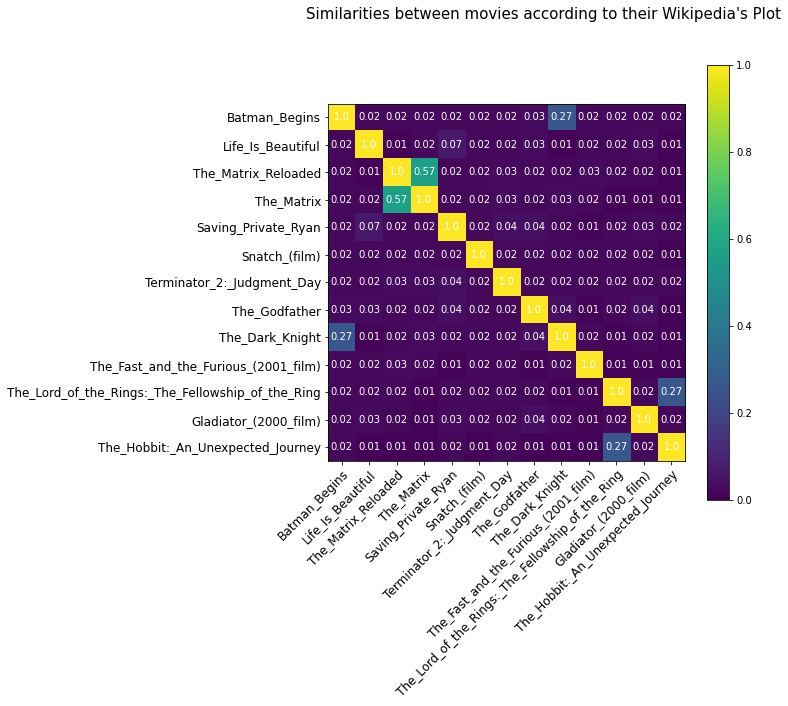

In [ ]:
heatmapplot(listwikipediapath)

**With a heatmap of movies's srt we observe better numbers of similarity.**

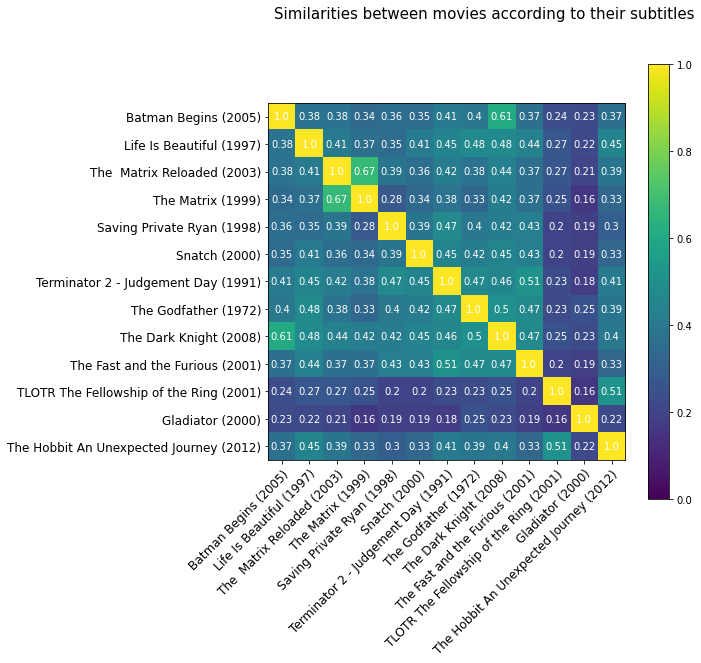

In [ ]:
heatmapsrt(listsrtfile)

**One explanation could be that srt's files have almost 6 time more information than the wikipedia's movies plot. The score difference it's more pronounce in wikipedia's plot but both point out the same movies with a possibility to be similar like:**
 
*   **The Dark Knight - Batman Begins**
*   **Matrix - Matrix Reloaded**
*   **The Lord of the Rings: The Fellowship of the Ring - The Hobbit: An Unexpected Journey bold text**

In [ ]:
var = 0
for a in listwikipediapath:
  var+=len(scrap1(a))
print(f'Length average of wikipedia\'s movies plot: {round(var/len(listwikipediapath), 1)}')

var = 0
for a in listsrtfile:
  var+=len(clean2(srttotext(a)))
print(f'Length average of movies\'s srt: {round(var/len(listsrtfile), 1)}')

Length average of wikipedia's movies plot: 4249.4
Length average of movies's srt: 28099.3


**We take a look to the wordcloud of 4 movies. We have to take into account that the plot explain the movie while the srt's files are the conversation of the movies.**

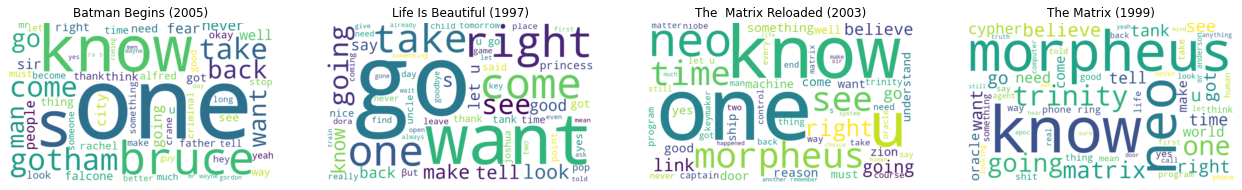

In [ ]:
wordcloud_srt(listsrtfile[:4])

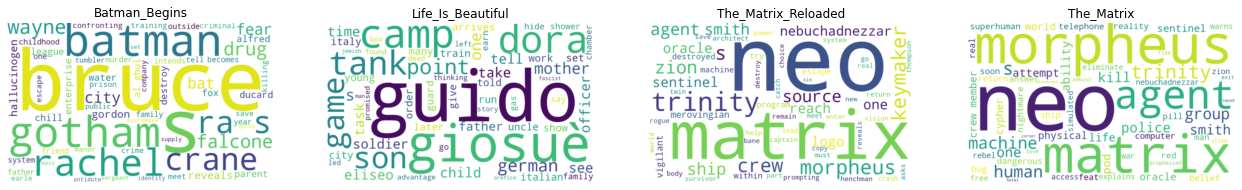

In [ ]:
wordcloud_plot(listwikipediapath[:4])